<a href="https://colab.research.google.com/github/rakhmantore/build2/blob/master/Football_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pandas-profiling==2.*
    !pip install pdpbox
    !pip install shap

In [2]:
import pandas as pd


In [7]:
!wget https://github.com/rakhmantore/build2/blob/master/events.csv.zip

--2020-08-29 03:30:24--  https://github.com/rakhmantore/build2/blob/master/events.csv.zip
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘events.csv.zip’

events.csv.zip          [ <=>                ]  74.50K  --.-KB/s    in 0.03s   

2020-08-29 03:30:26 (2.85 MB/s) - ‘events.csv.zip’ saved [76286]



In [9]:
!unzip events.csv


Archive:  events.csv.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of events.csv or
        events.csv.zip, and cannot find events.csv.ZIP, period.


In [3]:

import numpy as np
import matplotlib as plt
from matplotlib import pyplot
import scipy as sp
from xgboost import XGBClassifier
import sklearn
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint, uniform
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import cohen_kappa_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPClassifier



/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
events = pd.read_csv('events.csv')
ginf = pd.read_csv('ginf.csv')

In [8]:
ginf = ginf[ginf['id_odsp'].isin(events['id_odsp'].unique())]

In [9]:
ginf.shape

(9074, 18)

In [10]:
events.shape

(941009, 22)

In [11]:
df=events.merge(ginf,how='left', left_on='id_odsp', right_on='id_odsp')

In [ ]:
df.shape

(941009, 39)

In [12]:
df=df.drop(columns='adv_stats')

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 941009 entries, 0 to 941008
Data columns (total 38 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   id_odsp        941009 non-null  object 
 1   id_event       941009 non-null  object 
 2   sort_order     941009 non-null  int64  
 3   time           941009 non-null  int64  
 4   text           941009 non-null  object 
 5   event_type     941009 non-null  int64  
 6   event_type2    214293 non-null  float64
 7   side           941009 non-null  int64  
 8   event_team     941009 non-null  object 
 9   opponent       941009 non-null  object 
 10  player         880009 non-null  object 
 11  player2        291310 non-null  object 
 12  player_in      51715 non-null   object 
 13  player_out     51738 non-null   object 
 14  shot_place     227459 non-null  float64
 15  shot_outcome   228498 non-null  float64
 16  is_goal        941009 non-null  int64  
 17  location       467067 non-nul

In [ ]:
from pandas_profiling import ProfileReport
profile1 = ProfileReport(df, minimal=True).to_notebook_iframe()

profile1

In [14]:
df['event_type2'].value_counts(dropna=False)


NaN     726716
12.0    167859
13.0     43475
14.0      2258
15.0       701
Name: event_type2, dtype: int64

In [15]:
df.isna().sum()

id_odsp               0
id_event              0
sort_order            0
time                  0
text                  0
event_type            0
event_type2      726716
side                  0
event_team            0
opponent              0
player            61000
player2          649699
player_in        889294
player_out       889271
shot_place       713550
shot_outcome     712511
is_goal               0
location         473942
bodypart         711824
assist_method         0
situation        711872
fast_break            0
link_odsp             0
date                  0
league                0
season                0
country               0
ht                    0
at                    0
fthg                  0
ftag                  0
odd_h                 0
odd_d                 0
odd_a                 0
odd_over         842329
odd_under        842329
odd_bts          842329
odd_bts_n        842329
dtype: int64

In [16]:
shots = df[(df.event_type==1)]


In [17]:
shots_prediction = shots.loc[:,'is_goal':'fast_break']

In [19]:
shots1 = events[(events.event_type==1)]

In [21]:
shots_prediction1 = shots1.iloc[:,-6:]

In [22]:
X = shots_prediction.iloc[:,1:]
y = shots_prediction.iloc[:, 0]
print(X.shape)
print(y.shape)

(229135, 5)
(229135,)


In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=1)

In [24]:
pipeline = make_pipeline(
    SimpleImputer(),
    XGBClassifier()
)
param_distributions = { 

    'simpleimputer__strategy': ['mean', 'median'], 
    'xgbclassifier__n_estimators': [100,500,1000], 
    'xgbclassifier__max_depth': [3, 5, 7, 9]
}

search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_distributions, 
    n_iter=10, 
    cv=3, 
    scoring='accuracy', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1
)


search.fit(X_train, y_train);



Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   44.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 15.3min finished


In [25]:
model = search.best_estimator_

In [26]:
model


Pipeline(memory=None,
         steps=[('simpleimputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='mean',
                               verbose=0)),
                ('xgbclassifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, learning_rate=0.1,
                               max_delta_step=0, max_depth=3,
                               min_child_weight=1, missing=None,
                               n_estimators=500, n_jobs=1, nthread=None,
                               objective='binary:logistic', random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               seed=None, silent=None, subsample=1,
                               verbosity=1))],
         verbose=False)

In [27]:
k = 3
scores = cross_val_score(model, X_train, y_train, cv=k, 
                         scoring='accuracy')
print(f'accuracy for {k} folds:', scores)
print(scores.mean())

# Get your model's test accuracy
y_pred = model.predict(X_test)

from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

accuracy for 3 folds: [0.91082867 0.9101841  0.91004129]
0.9103513545320414


0.9109828175266216

In [28]:
accuracy = model.score(X_test, y_test)
y_pred = model.predict_proba(X_test)
predict = model.predict(X_test)
y_total = y_train.count()
y_positive = y_train.sum()
auc_roc = roc_auc_score(y_test, y_pred[:, 1])

y_pred_train = model.predict_proba(X_train)
val_auc_roc = roc_auc_score(y_train, y_pred_train[:, 1])
print('The training set contains {} examples (shots) of which {} are positives (goals).'.format(y_total, y_positive))
print('The accuracy of classifying whether a shot is goal or not is {:.2f} %'.format(accuracy*100))
print('Our classifier obtains a test AUC-ROC of {:.4f}.'.format(auc_roc))
print('Our classifier obtains a validation AUC-ROC of {:.4f}.'.format(val_auc_roc))

The training set contains 148937 examples (shots) of which 15937 are positives (goals).
The accuracy of classifying whether a shot is goal or not is 91.10 %
Our classifier obtains a test AUC-ROC of 0.8191.
Our classifier obtains a validation AUC-ROC of 0.8169.


In [29]:
transformers = make_pipeline(
    SimpleImputer(strategy='median')
)
X_train_transformed = transformers.fit_transform(X_train)

In [30]:
X_test_transformed = transformers.fit_transform(X_test)

In [31]:
model2 = XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, learning_rate=0.1,
                               max_delta_step=0, max_depth=3,
                               min_child_weight=1, missing=None,
                               n_estimators=500, n_jobs=1, nthread=None,
                               objective='binary:logistic', random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               seed=None, silent=None, subsample=1,
                               verbosity=1)

In [32]:
model2.fit(X_train_transformed, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=500, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [33]:
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(
    model2, #What is the model?
    scoring='roc_auc', #What scoring parameter do you want to use?
    n_iter=5, #How many of random shuffles? 
    random_state=42 
)

permuter.fit(X_train_transformed, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


PermutationImportance(cv='prefit',
                      estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                              colsample_bylevel=1,
                                              colsample_bynode=1,
                                              colsample_bytree=1, gamma=0,
                                              learning_rate=0.1,
                                              max_delta_step=0, max_depth=3,
                                              min_child_weight=1, missing=None,
                                              n_estimators=500, n_jobs=1,
                                              nthread=None,
                                              objective='binary:logistic',
                                              random_state=0, reg_alpha=0,
                                              reg_lambda=1, scale_pos_weight=1,
                                              seed=None, silent=None,
                     

In [34]:
feature_names1 = X_train.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names1).sort_values()

bodypart         0.009694
fast_break       0.011341
assist_method    0.018685
situation        0.020102
location         0.272216
dtype: float64

In [35]:
# 2. Display permutation importances
eli5.show_weights(
    permuter, 
    top=None, # No limit: show permutation importances for all features
    feature_names=feature_names1 # must be a list
)

Weight,Feature
0.2722 ± 0.0024,location
0.0201 ± 0.0015,situation
0.0187 ± 0.0008,assist_method
0.0113 ± 0.0004,fast_break
0.0097 ± 0.0008,bodypart


In [36]:
permuter.fit(X_test_transformed, y_test)

PermutationImportance(cv='prefit',
                      estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                              colsample_bylevel=1,
                                              colsample_bynode=1,
                                              colsample_bytree=1, gamma=0,
                                              learning_rate=0.1,
                                              max_delta_step=0, max_depth=3,
                                              min_child_weight=1, missing=None,
                                              n_estimators=500, n_jobs=1,
                                              nthread=None,
                                              objective='binary:logistic',
                                              random_state=0, reg_alpha=0,
                                              reg_lambda=1, scale_pos_weight=1,
                                              seed=None, silent=None,
                     

In [37]:
feature_names2 = X_test.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names2).sort_values()

bodypart         0.008811
fast_break       0.011503
assist_method    0.019293
situation        0.020533
location         0.273985
dtype: float64

In [38]:
eli5.show_weights(
    permuter, 
    top=None, # No limit: show permutation importances for all features
    feature_names=feature_names2 # must be a list
)

Weight,Feature
0.2740 ± 0.0048,location
0.0205 ± 0.0030,situation
0.0193 ± 0.0024,assist_method
0.0115 ± 0.0009,fast_break
0.0088 ± 0.0014,bodypart


In [39]:
auc_pr_baseline = y_positive / y_total

In [40]:
print('The baseline performance for AUC-PR is {:.2f}. This is the AUC-PR that what we would get by random guessing.'.format(auc_pr_baseline))

The baseline performance for AUC-PR is 0.11. This is the AUC-PR that what we would get by random guessing.


In [41]:
auc_pr = average_precision_score(y_test, y_pred[:, 1])
print('Our classifier obtains an AUC-PR of {:.4f}.'.format(auc_pr))

Our classifier obtains an AUC-PR of 0.4737.


In [42]:
cohen_kappa = cohen_kappa_score(y_test,predict)
print('Our classifier obtains a Cohen Kappa of {:.4f}.'.format(cohen_kappa))

Our classifier obtains a Cohen Kappa of 0.3518.


In [43]:
print('Confusion Matrix:')
print(confusion_matrix(y_test,predict))
print('Report:')
print(classification_report(y_test,predict))


Confusion Matrix:
[[70784   910]
 [ 6229  2275]]
Report:
              precision    recall  f1-score   support

           0       0.92      0.99      0.95     71694
           1       0.71      0.27      0.39      8504

    accuracy                           0.91     80198
   macro avg       0.82      0.63      0.67     80198
weighted avg       0.90      0.91      0.89     80198



In [44]:


predictions = X_test.copy()
predictions['true_goals'] = y_test
predictions['expected_goals'] = y_pred[:,1]
predictions['difference'] = predictions['expected_goals'] - predictions['true_goals']
print(predictions.shape)
predictions = predictions.iloc[:,5:8]
predictions.head()


(80198, 8)


,true_goals,expected_goals,difference
851561,0,0.181329,0.181329
744702,1,0.164668,-0.835332
661032,0,0.019665,0.019665
195074,0,0.181329,0.181329
742812,0,0.028015,0.028015


In [45]:
#partial dependence plot with 1 feature
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 72

In [46]:
X_train_transformed = pd.DataFrame(X_train_transformed, columns=X_train.columns)

In [47]:
type(X_test_transformed)

numpy.ndarray

In [52]:
X_test_transformed.sample(5)

,location,bodypart,assist_method,situation,fast_break
4166,3.0,3.0,2.0,3.0,0.0
65835,15.0,2.0,0.0,1.0,0.0
21603,15.0,1.0,3.0,1.0,0.0
51932,15.0,1.0,1.0,1.0,0.0
63017,3.0,2.0,1.0,1.0,0.0


In [49]:
X_train_transformed.sample(5)

,location,bodypart,assist_method,situation,fast_break
76732,3.0,3.0,2.0,3.0,0.0
74092,3.0,2.0,2.0,1.0,0.0
11358,13.0,1.0,3.0,3.0,0.0
107984,15.0,2.0,0.0,4.0,0.0
56339,15.0,1.0,1.0,1.0,0.0


In [50]:
X_test_transformed.shape

(80198, 5)

In [51]:
X_test_transformed = pd.DataFrame(X_test_transformed, columns=X_test.columns)

In [53]:
X_test_transformed.shape

(80198, 5)

In [54]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'location' #define feature for plot 


isolated1 = pdp_isolate(
    model=model, #specify model
    dataset=X_train_transformed, #specify dataset (validation)
    model_features=X_train.columns, #specify all the features
    feature=feature #
)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


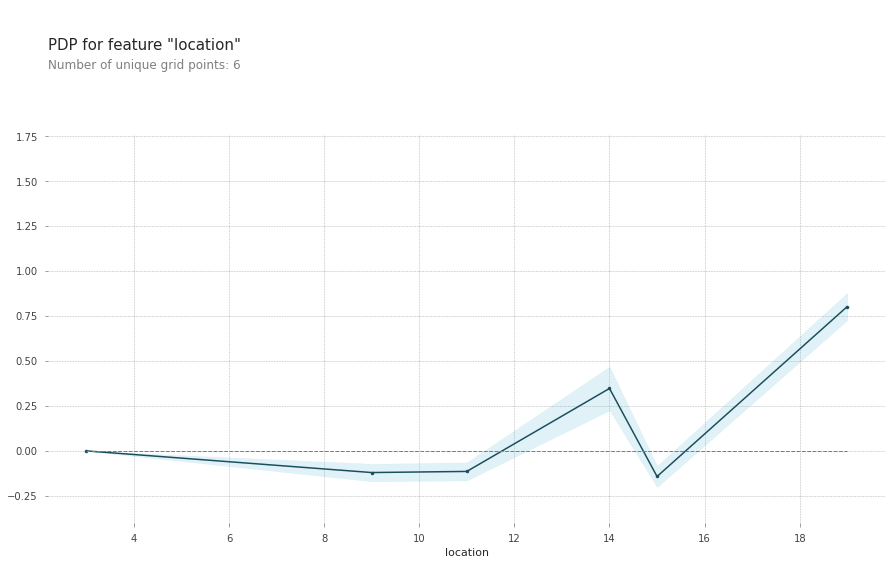

In [ ]:
pdp_plot(isolated1, feature_name=feature);

In [55]:
isolated2 = pdp_isolate(
    model=model, #specify model
    dataset=X_test_transformed, #specify dataset (validation)
    model_features=X_test.columns, #specify all the features
    feature=feature #
)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


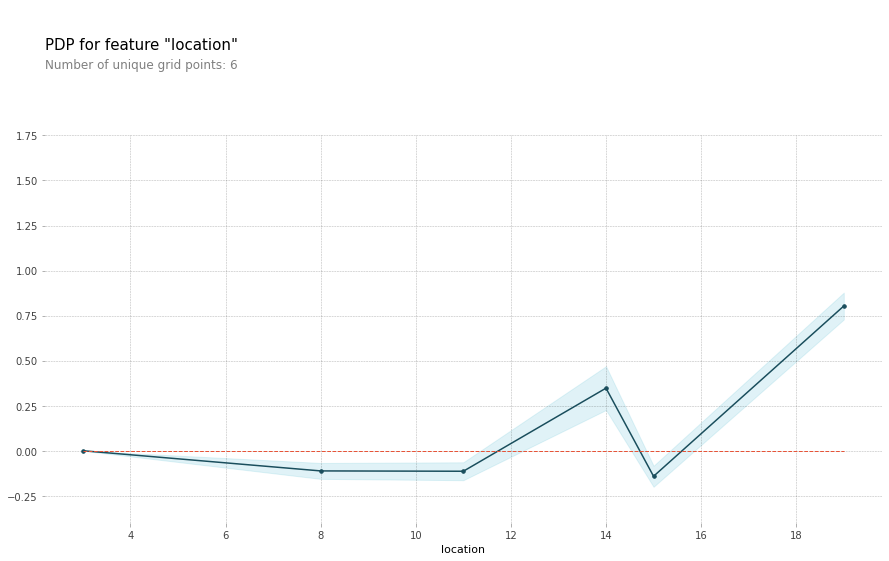

In [56]:
pdp_plot(isolated2, feature_name=feature);

In [57]:
feature2 = 'situation' #define feature for plot 


isolated3 = pdp_isolate(
    model=model, #specify model
    dataset=X_train_transformed, #specify dataset (validation)
    model_features=X_train.columns, #specify all the features
    feature=feature2 #
)

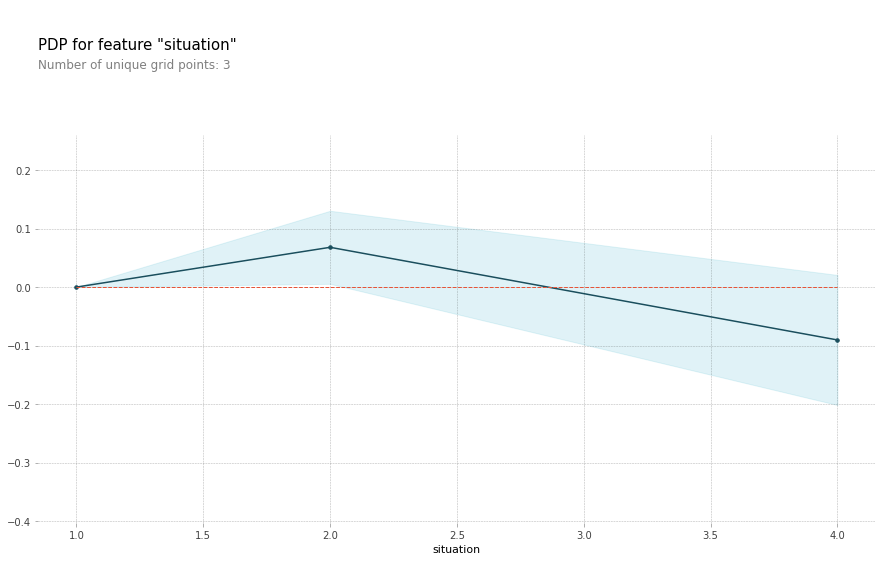

In [58]:
pdp_plot(isolated3, feature_name=feature2);

In [59]:
isolated4 = pdp_isolate(
    model=model, #specify model
    dataset=X_test_transformed, #specify dataset (validation)
    model_features=X_test.columns, #specify all the features
    feature=feature2 #
)

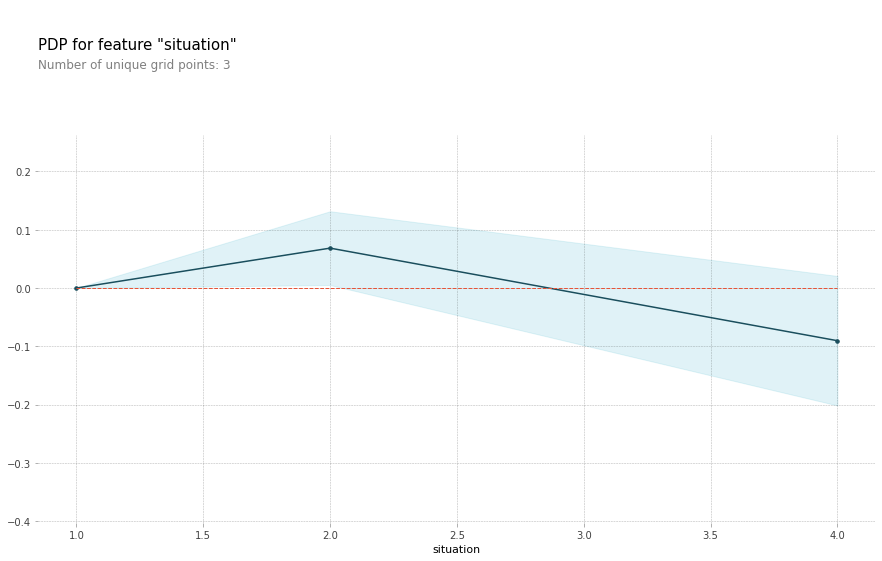

In [60]:
pdp_plot(isolated4, feature_name=feature2);

In [ ]:
#Logistic Regression

In [61]:
dummies = pd.get_dummies(shots_prediction, columns=['location', 'bodypart','assist_method', 'situation'])

In [62]:
!wget dummies.columns = ['is_goal', 'fast_break', 'loc_centre_box', 'loc_diff_angle_lr', 'diff_angle_left', 'diff_angle_right', 'left_side_box', 'left_side_6ybox', 'right_side_box', 'right_side_6ybox', 'close_range', 'penalty', 'outside_box', 'long_range', 'more_35y', 'more_40y', 'not_recorded', 'right_foot', 'left_foot', 'header', 'no_assist', 'assist_pass', 'assist_cross', 'assist_header', 'assist_through_ball', 'open_play', 'set_piece', 'corner', 'free_kick']
dummies.head()

,is_goal,fast_break,loc_centre_box,loc_diff_angle_lr,diff_angle_left,diff_angle_right,left_side_box,left_side_6ybox,right_side_box,right_side_6ybox,close_range,penalty,outside_box,long_range,more_35y,more_40y,not_recorded,right_foot,left_foot,header,no_assist,assist_pass,assist_cross,assist_header,assist_through_ball,open_play,set_piece,corner,free_kick
0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0
11,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0
13,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0
14,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0
17,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0


In [63]:
X1 = dummies.iloc[:,1:]
y1 = dummies.iloc[:,0]
print(X1.shape)
print(y1.shape)

(229135, 28)
(229135,)


In [64]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.35, random_state=1)

In [65]:
logistic_regression = LogisticRegression()
logistic_regression.fit(X1_train, y1_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [66]:
accuracy_logreg = logistic_regression.score(X1_test, y1_test)
y_pred_logreg = logistic_regression.predict_proba(X1_test)
predict_logreg = logistic_regression.predict(X1_test)
y_total_logreg = y1_train.count()
y_positive_logreg = y1_train.sum()
auc_roc_logreg = roc_auc_score(y1_test, y_pred_logreg[:, 1])

y_pred_train_logreg = logistic_regression.predict_proba(X1_train)
val_auc_roc_logreg = roc_auc_score(y1_train, y_pred_train_logreg[:, 1])
print('The training set contains {} examples (shots) of which {} are positives (goals).'.format(y_total_logreg, y_positive_logreg))
print('The accuracy of classifying whether a shot is goal or not is {:.2f} %'.format(accuracy_logreg*100))
print('Our classifier obtains an AUC-ROC of {:.4f}.'.format(auc_roc_logreg))
print('Our classifier obtains a validation AUC-ROC of {:.4f}.'.format(val_auc_roc_logreg))

auc_pr_baseline = y_positive / y_total
print('The baseline performance for AUC-PR is {:.4f}. This is the AUC-PR that what we would get by random guessing.'.format(auc_pr_baseline))
auc_pr_logreg = average_precision_score(y1_test, y_pred_logreg[:, 1])
print('Our classifier obtains an AUC-PR of {:.4f}.'.format(auc_pr_logreg))
cohen_kappa_logreg = cohen_kappa_score(y1_test,predict_logreg)
print('Our classifier obtains a Cohen Kappa of {:.4f}.'.format(cohen_kappa_logreg))

The training set contains 148937 examples (shots) of which 15937 are positives (goals).
The accuracy of classifying whether a shot is goal or not is 91.10 %
Our classifier obtains an AUC-ROC of 0.8176.
Our classifier obtains a validation AUC-ROC of 0.8145.
The baseline performance for AUC-PR is 0.1070. This is the AUC-PR that what we would get by random guessing.
Our classifier obtains an AUC-PR of 0.4708.
Our classifier obtains a Cohen Kappa of 0.3484.


In [67]:
#Cohen Kappa of less than 0.4 is pretty low. I believe this is caused by the imbalance of values.

In [68]:
print('Confusion Matrix:')
print(confusion_matrix(y1_test,predict_logreg))
print('Report:')
print(classification_report(y1_test,predict_logreg))

Confusion Matrix:
[[70820   874]
 [ 6265  2239]]
Report:
              precision    recall  f1-score   support

           0       0.92      0.99      0.95     71694
           1       0.72      0.26      0.39      8504

    accuracy                           0.91     80198
   macro avg       0.82      0.63      0.67     80198
weighted avg       0.90      0.91      0.89     80198



In [69]:
coefficients = pd.Series(logistic_regression.coef_[0], X1_train.columns)
print(coefficients)

fast_break             1.716896
loc_centre_box         0.263432
loc_diff_angle_lr     -1.658101
diff_angle_left       -0.759562
diff_angle_right      -0.916074
left_side_box         -1.086378
left_side_6ybox        0.603197
right_side_box        -1.002465
right_side_6ybox       0.594140
close_range            2.039004
penalty                2.279787
outside_box           -1.781293
long_range            -2.189157
more_35y              -2.464634
more_40y              -1.985552
not_recorded           7.116433
right_foot            -0.085123
left_foot             -0.146379
header                -0.715720
no_assist             -0.276982
assist_pass           -0.247577
assist_cross          -0.621152
assist_header         -0.503733
assist_through_ball    0.702221
open_play             -0.116711
set_piece              0.639352
corner                 0.354585
free_kick             -1.824449
dtype: float64


In [70]:
#Player Analysis

In [71]:
ypred2 = model.predict_proba(X_train)
predictions_train = X_train.copy()
predictions_train['true_goals'] = y_train
predictions_train['expected_goals'] = ypred2[:,1]
predictions_train['difference'] = predictions_train['expected_goals'] - predictions_train['true_goals']
predictions_train.shape

(148937, 8)

In [72]:
predictions_train = predictions_train.iloc[:,5:8]
all_predictions = pd.concat([predictions, predictions_train], axis=0)


In [73]:
predictions.shape

(80198, 3)

In [74]:
predictions_train.shape

(148937, 3)

In [75]:
all_predictions.shape

(229135, 3)

In [76]:
events.shape

(941009, 22)

In [77]:
events2 = pd.concat([events, all_predictions], axis=1)
shots2 = events2[events2.event_type==1]

In [78]:
events2.shape

(941009, 25)

In [79]:
shots2.shape

(229135, 25)

In [80]:
xG_players = shots2[['player', 'event_type', 'true_goals', 'expected_goals', 'difference']].groupby('player').sum()
xG_players.columns = ['n_shots', 'goals_scored', 'expected_goals', 'difference']
xG_players[['goals_scored', 'expected_goals']].corr()


,goals_scored,expected_goals
goals_scored,1.000000,0.977248
expected_goals,0.977248,1.000000


In [81]:
xG_players.shape

(4787, 4)

In [82]:
xG_players.sample(5)

,n_shots,goals_scored,expected_goals,difference
player,,,,
jesus vazquez,2,0.0,0.196587,0.196587
aaron,48,1.0,3.504341,2.504341
marvin matip,37,2.0,4.710269,2.710269
dominique heintz,13,2.0,1.271912,-0.728088
walter gargano,55,3.0,2.626139,-0.373861


In [83]:


xG_players.sort_values(['difference', 'goals_scored'])



,n_shots,goals_scored,expected_goals,difference
player,,,,
lionel messi,914,205.0,146.124664,-58.875332
zlatan ibrahimovic,774,153.0,119.175606,-33.824394
cristiano ronaldo,1190,198.0,165.817688,-32.182316
gonzalo higuain,552,118.0,85.968857,-32.031139
luis suarez,433,96.0,64.544716,-31.455286
...,...,...,...,...
adrian mutu,197,17.0,25.324188,8.324189
giampaolo pazzini,233,31.0,39.525616,8.525616
mats hummels,121,10.0,18.959757,8.959756


In [84]:
xG_players.sort_values(['expected_goals'], ascending=False)

,n_shots,goals_scored,expected_goals,difference
player,,,,
cristiano ronaldo,1190,198.0,165.817688,-32.182316
lionel messi,914,205.0,146.124664,-58.875332
zlatan ibrahimovic,774,153.0,119.175606,-33.824394
edinson cavani,623,121.0,114.413246,-6.586751
robert lewandowski,633,124.0,97.521606,-26.478395
...,...,...,...,...
jon serantes,1,0.0,0.013337,0.013337
moi,1,0.0,0.010570,0.010570
hassane kamara,1,0.0,0.008422,0.008422
